# Model Playground
Based on Bellotti et al.'s "Adaptive Experience Engine for Serious Games"

Note: In the models below, there is a difference between calling "make" and "set" for an instance.
* calling the "make" function will create an instance attribute from scratch everytime
* calling the "set" function will _modify_ an existing attribute everytime

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Helper Functions

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

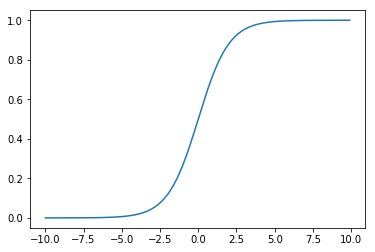

In [3]:
# plot of the original sigmoid function
x = np.arange(-10,10,0.1)
y = sigmoid(x)
plt.plot(x,y)
plt.show()

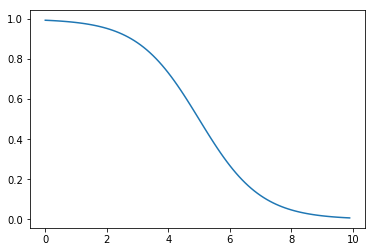

In [4]:
# plot of the transformed sigmoid function
# that will be used for the Task model's skill benefit curve
x = np.arange(0,10,0.1)
y = sigmoid(-(x-5))
plt.plot(x,y)
plt.show()

## Predefined Constants

In [5]:
NUM_LEVELS = 10
TYPES = set()
SKILLS = set()
LEARNING_STYLES = set()

## Task Model

In [6]:
# TODO: print messages
# TODO: implement the difficulty adaptation range
# Note: I have chosen to omit the "Place" parameter because I will not be using it

class Task:
    def make_types(self, **kwargs):
        # key: string (task type)
        # value: int/float (numeric extent to which this task covers the associated type)
        # all values are normalized to add up to 1
        total = sum(kwargs.values())
        self.types = dict()
        for t in kwargs:
            if t in TYPES:
                self.types[t] = kwargs[t]/total
            else:
                print("Type {} has not been predefined and therefore has not been added to the task."\
                      .format(t))
            
    def make_val(self, symbol, val, range=5):
        # setting values such that they are normalized to 0..1
        if symbol == 'E':
            self.entertainment_val = val/range
        elif symbol == 'Q':
            self.quality_val = val/range
        elif symbol == 'L':
            self.length = val/range
        elif symbol == 'IL':
            self.interactivity_level = val/range
        
    def make_skill_relevance(self, **kwargs):
        # key: string (skill name)
        # value: int/float (numeric extent to which this task covers the associated skill)
        # all values are normalized to add up to 1
        total = sum(kwargs.values())
        self.skill_relevance = dict()
        for skill in kwargs:
            if skill in SKILLS:
                self.skill_relevance[skill] = kwargs[skill]/total
            else:
                print("Skill {} has not been predefined and therefore has not been added to the task."\
                      .format(skill))
        
    def calc_skill_benefits(self, arg):
        # for each skill, we calculate skill benefit = sigmoid(-(x-5))
        # x is the player's ability level in the skill
        # the transformed sigmoid is a 0-1 normalized s-curve in the range of x=0..10
        # for now, I will use the same skill benefit function for all skills
        
        if isinstance(arg, User):  # input is a user
            if hasattr(self, 'skill_relevance'):
                skill_benefits = dict()
                for skill in self.skill_relevance:
                    x = arg.skill_levels[skill]  # user's skill level is in range 0..1
                    x = x*10  # scale the skill level to 0..10
                    skill_benefits[skill] = sigmoid(-(x-5))
                return skill_benefits
            else:
                print("Could not calculate skill benefits because make_skill_relevance has not been called.")
            
        elif isinstance(arg, (float,int)):
            # input is a numeric skill level for one skill
            x = arg*(10/NUM_LEVELS)  # scale to range 0..10
            return sigmoid(-(x-5))
    
    def calc_difficulty(self):
        # estimate the difficulty of this task instance
        # as a function of skill benefits, which are weighted by the corresponding skill relevance
        if hasattr(self, 'skill_relevance'):
            sum_outer = 0
            for skill in self.skill_relevance:
                sum_inner = 0
                for j in range(NUM_LEVELS):
                    sum_inner += j*self.calc_skill_benefits(j)
                sum_outer += self.skill_relevance[skill]*sum_inner
            return sum_outer
        else:
            print("Could not calculate difficulty because make_skill_relevance has not been called.")
            
    # TODO: difficulty adaptation range
        
    def make_learning_styles(self, **kwargs):
        # key: string (learning style)
        # value: int/float (numeric extent to which this task covers the associated style)
        # all values are normalized to add up to 1
        total = sum(kwargs.values())
        self.learning_styles = dict()
        for style in kwargs:
            if style in LEARNING_STYLES:
                self.learning_styles[style] = kwargs[style]/total
            else:
                print("Learning style {} has not been predefined and therefore has not been added to the task."\
                      .format(style))
        
    def make_dependencies(self, **args):
        self.dependencies = set()
        for task in args:  # the current Task instance depends on these other Task instances
            self.dependencies.add(task)

## User Model

In [8]:
# Note: I have chosen to omit the "Navigation Ability Level" parameter because I will not be using it
# "Navigation Ability Level" is associated with the Task model's "Place" parameter,
# which I will also not be using

class User:
    def __init__(self):
        self.skill_levels = {skill:0 for skill in SKILLS}
        
        self.type_pref_unscaled = {t:0 for t in TASK_TYPES}
        self.type_pref_scaled = {t:0 for t in TASK_TYPES}
        
        self.skill_pref_unscaled = {s:0 for s in SKILLS}
        self.skill_pref_scaled = {s:0 for s in SKILLS}
        
        self.learning_style_pref_unscaled = {ls:0 for ls in LEARNING_STYLES}
        self.learning_style_pref_scaled = {ls:0 for ls in LEARNING_STYLES}
        
    def set_skill_level(self, skill, level):
        if skill in SKILLS:
            self.skill_levels[skill] = level/NUM_LEVELS  # normalize to range 0..1
        else:
            print("Skill {} has not been predefined and therefore will not be included in the user's skill levels."\
                      .format(skill))
            
    def set_type_pref(self, **kwargs):
        # key: string (task type)
        # value: int/float (numeric preference for the associated type)
        for t in kwargs:
            if t in TYPES:
                self.type_pref_unscaled[t] = kwargs[t]
            else:
                print("Type {} has not been predefined and therefore will not be included in the user's preferences."\
                      .format(t))
        
        # all values in type_pref_unscaled are normalized/scaled to add up to 1
        total = sum(self.types_pref_unscaled.values())
        for t in self.types_pref_unscaled:
            self.type_pref_scaled[t] = self.type_pref_unscaled[t]/total
                
    def set_skill_pref(self, **kwargs):
        # key: string (skill)
        # value: int/float (numeric preference for the associated skill)
        for skill in kwargs:
            if t in SKILLS:
                self.skill_pref_unscaled[skill] = kwargs[skill]
            else:
                print("Skill {} has not been predefined and therefore will not be included in the user's preferences."\
                      .format(skill))
        
        # all values in skill_pref_unscaled are normalized/scaled to add up to 1
        total = sum(self.skill_pref_unscaled.values())
        for t in self.skill_pref_unscaled:
            self.skill_pref_scaled[skill] = self.skill_pref_unscaled[skill]/total
            
    def set_learning_style_pref(self, **kwargs):
        # key: string (skill)
        # value: int/float (numeric preference for the associated learning style)
        for style in kwargs:
            if style in LEARNING_STYLES:
                self.learning_style_pref_unscaled[style] = kwargs[style]
            else:
                print("Learning style {} has not been predefined and therefore will not be included in the user's preferences."\
                      .format(style))
        
        # all values in learning_style_pref_unscaled are normalized/scaled to add up to 1
        total = sum(self.learning_style_pref_unscaled.values())
        for style in self.learning_style_pref_unscaled:
            self.learning_style_pref_scaled[style] = self.learning_style_pref_unscaled[style]/total
                
                

In [9]:
# TODO: user-task parameters